In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score

In [6]:
from sklearn.metrics import confusion_matrix, classification_report, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [7]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier

## Initial observations

In [8]:
df = pd.read_csv('/home/padmac/kaggle/exoplanets/exoTrain.csv', nrows=400)

In [9]:
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 9.8 MB


In [11]:
# check nulls 
any(df.isnull().all())

False

In [12]:
# Check data balance
df['LABEL'].value_counts()

1    363
2     37
Name: LABEL, dtype: int64

In [13]:
# list some of the records with label 1
df[df['LABEL']==1].head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
37,1,-141.22,-81.79,-52.28,-32.45,-1.55,-35.61,-23.28,19.45,53.11,...,-50.79,-22.34,-36.23,27.44,13.52,38.66,-17.53,31.49,31.38,50.03
38,1,-35.62,-28.55,-27.29,-28.94,-15.13,-51.06,2.67,-5.21,9.67,...,-43.98,-38.22,-46.23,-54.40,-23.51,-26.96,-3.95,-0.34,10.52,-7.69
39,1,142.40,137.03,93.65,105.64,98.22,99.06,86.40,60.78,45.18,...,-0.99,-3.03,-30.27,-24.22,-35.10,-39.64,23.78,23.40,-0.50,0.97
40,1,-167.02,-137.65,-150.05,-136.85,-98.73,-103.14,-107.70,-123.19,-125.65,...,-97.43,-79.79,-80.62,-78.22,-105.06,-69.67,-90.45,-73.67,-66.71,-66.07
41,1,207.74,223.60,246.15,224.06,210.77,189.56,172.68,170.31,148.79,...,-53.06,-136.92,-174.97,-180.46,-164.01,-126.58,84.05,63.81,108.36,78.10


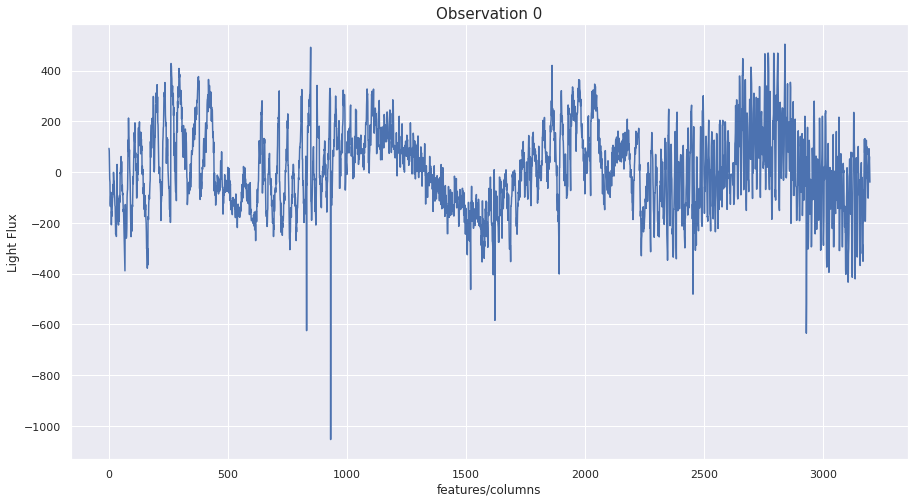

In [15]:
flux_plot(df, 0)

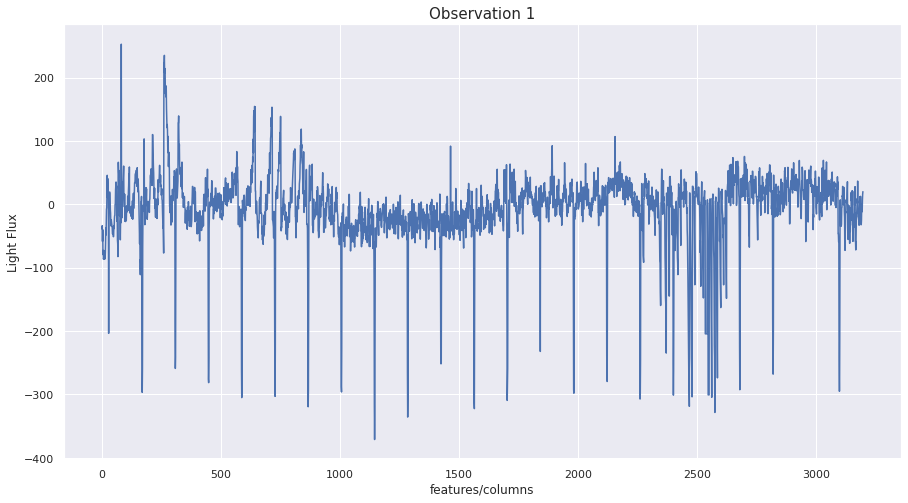

In [16]:
flux_plot(df, 1)

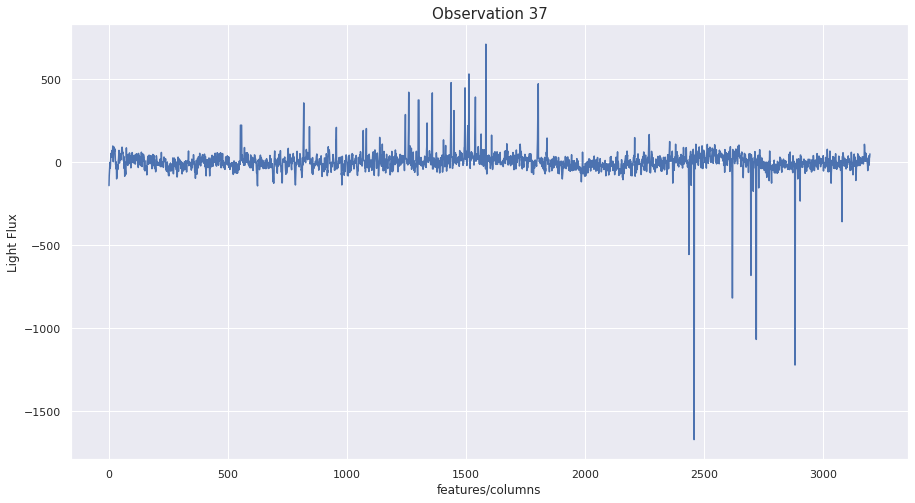

In [17]:
flux_plot(df, 37)

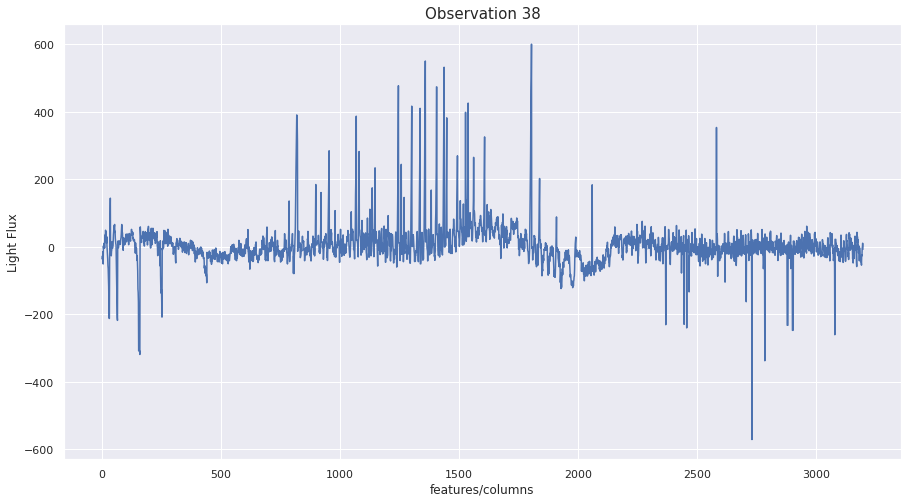

In [18]:
flux_plot(df, 38)

In [14]:
import random, os
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [15]:
seed_everything(42)

## Split into train/test & get Baseline score

In [16]:
df['LABEL'] = df['LABEL'].replace(1, 0)
df['LABEL'] = df['LABEL'].replace(2, 1)

In [17]:
df['LABEL'].value_counts()

0    363
1     37
Name: LABEL, dtype: int64

In [18]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [19]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [21]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)

# Fit xg_reg to training set
model.fit(X_train, y_train)

# Predict labels of test set, y_pred
y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('Score: ' + str(score))

Score: 0.87


In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        89
           1       0.25      0.09      0.13        11

    accuracy                           0.87       100
   macro avg       0.57      0.53      0.53       100
weighted avg       0.82      0.87      0.84       100



In [23]:
confusion_matrix(y_test, y_pred)

array([[86,  3],
       [10,  1]])

In [24]:
recall_score(y_test, y_pred)
#recall_score(y_test, y_pred, pos_label=2)

0.09090909090909091

In [30]:
type(y_test), type(y_pred)

(pandas.core.series.Series, numpy.ndarray)

In [26]:
majority_minority_weight = 363/37

In [27]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = XGBClassifier(scale_pos_weight=majority_minority_weight, random_state=42)
scores = cross_val_score(model, X, y, cv=kfold, scoring='recall')
print('Recall: {} mean recall: {}'.format(scores, scores.mean()))

Recall: [0.25       0.125      0.57142857 0.14285714 0.28571429] mean recall: 0.275


## Hyperparameter tuning

In [28]:
def search_for_optimal_params(
    X, y, params,
    model=XGBClassifier(random_state=42, scale_pos_weight=majority_minority_weight), 
    random=False, random_state=42,
    scorer='recall'):
    
    if random:
        grid = RandomizedSearchCV(model, params, cv=kfold, random_state=random_state, scoring=scorer)
    else:
        grid = GridSearchCV(model, params, cv=kfold, scoring=scorer)
    
    grid.fit(X, y)
    best_params = grid.best_params_
    best_score = grid.best_score_
    print('best params: {}\n\nbest score: {}'.format(best_params, best_score))

In [ ]:
params = {
    #'learning_rate':[0.01, 0.05, 0.1],
    #'n_estimators': [50, 100, 150],
    #'max_depth': [1, 2,4],
    #'subsample': [0.3, 0.5, 0.7],
    #'gamma': [0.02, 0.05, 0.1,0.5],
    #'colsample_by_tree':[0.3, 0.5, 0.7, 0.9]
}

In [29]:
params = {
    'learning_rate':[0.01, 0.001],
    'n_estimators': [50, 150, 200],
    'max_depth': [1,2],
    'subsample': [0.3, 0.9],
    'gamma': [0.02, 0.025],
    'colsample_by_tree':[0.1, 0.7]  
}

## Trying out the various models

In [30]:
train_df = pd.read_csv('/home/padmac/kaggle/exoplanets/exoTrain.csv')
train_df['LABEL'] = train_df['LABEL'].replace(1, 0)
train_df['LABEL'] = train_df['LABEL'].replace(2, 1)

In [31]:
train_df['LABEL'].value_counts()

0    5050
1      37
Name: LABEL, dtype: int64

In [32]:
# shuffle the training data
shuf_train_df = train_df.sample(frac=1)

In [33]:
X_train = shuf_train_df.iloc[:,1:]
y_train = shuf_train_df.iloc[:,0]

In [34]:
test_df = pd.read_csv('/home/padmac/kaggle/exoplanets/exoTest.csv')
test_df['LABEL'] = test_df['LABEL'].replace(1, 0)
test_df['LABEL'] = test_df['LABEL'].replace(2, 1)

In [35]:
X_test = test_df.iloc[:,1:]
y_test = test_df.iloc[:,0]
majority_minority_weight = 5050/37

In [36]:
def final_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rscore = recall_score(y_test, y_pred)
    print(rscore)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_pred)
    print('auc: {}'.format(auc))
    return rscore, auc

In [37]:
y_test.value_counts()

0    565
1      5
Name: LABEL, dtype: int64

In [ ]:
# RandomForest with class weighting

# changes the weight that each class has when calculating the "impurity" score of a chosen split point.
# Impurity measures how mixed the groups of samples are for a given split in the training dataset;
# this calculation can be forcibly biased so that a mixture in favor of the minority class is favored, 
# allowing some positives for the majority class.

# RandomForestClassifier(n_estimators= ..., class_weight='balanced')

In [ ]:
# Random Forest With Bootstrap Class Weighting

# Given that each decision tree is constructed from a 
# bootstrap sample (e.g. random selection with replacement), 
# the class distribution in the data sample will be different for each tree.

# So this changes the class weighting based on the class distribution in 
# each bootstrap sample, instead of the entire training dataset.

#This can be achieved by setting the class_weight argument to the value ‘balanced_subsample‘.

# RandomForestClassifier(n_estimators= ..., class_weight='balanced_subsample')

In [55]:
from collections import defaultdict, Counter
def get_models():
    xgb_weighted = XGBClassifier(
                        max_depth=1, 
                        n_estimators=50,
                        learning_rate=0.001,
                        gamma=0.02,
                        colsample_by_tree=0.1,
                        subsample=0.9,
                        scale_pos_weight=majority_minority_weight, 
                        random_state=42)
    
    xgb = XGBClassifier(
            max_depth=2, 
            n_estimators=50,
            learning_rate=0.001,
            gamma=0.02,
            colsample_by_tree=0.1,
            subsample=0.9,
            random_state=42)
    
    # EasyEnsemble uses UNDERSAMPLING of majority class with AdaBoost
    easy = EasyEnsembleClassifier(n_estimators=50, random_state=42)
    
    # This is using UNDERSAMPLING but XGBoost as the base estimator
    easy_xgb = EasyEnsembleClassifier(base_estimator=xgb, n_estimators=50, random_state=42)
    
    # RandomForest with Bootstrap class weighting
    rf_bal_subsample = RandomForestClassifier(n_estimators=50, class_weight='balanced_subsample')

    # RandomForest with class weighting
    rf_bal = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)
    
    # BalancedRandomForest uses undersampling of majority class
    bal_rf = BalancedRandomForestClassifier(n_estimators=50, random_state=42)
    
    models = {
     'xgb_weight': xgb_weighted,   
     'xgb_tuned': xgb,
     'easy_plain': easy,
     'easy_xgb': easy_xgb,
     'smote_xgb': xgb,
     'adasyn_xgb': xgb,
     'rf_subsample': rf_bal_subsample,
     'rf_bal': rf_bal,
     'bal_rf':bal_rf,
     
    }
    return models

In [70]:
def compare_scores_from_all_models(models, mname, scores):
    xtrain = X_train
    ytrain = y_train
    xtest = X_test
    ytest = y_test
    
    model = models[mname]
    print(type(model))
    
    print('=====Training Model: {}====='.format(mname))
    if mname == 'adasyn_xgb':
        X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)
        xtrain = X_resampled
        ytrain = y_resampled
        print('after ADASYN resampling: {}'.format(Counter(y_resampled)))
    elif mname == 'smote_xgb':
        X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
        print('after SMOTE resampling: {}'.format(Counter(y_resampled)))
        xtrain = X_resampled
        ytrain = y_resampled
        #recall = auc = 0
    recall, auc = final_model(xtrain, ytrain, xtest, ytest, model)

    scores['recall'].append(recall)
    scores['auc'].append(auc)
    scores['model_name'].append(mname)
    

In [57]:
scores = defaultdict(list)

In [62]:
models = get_models()

In [71]:
compare_scores_from_all_models(models, 'xgb_weight', scores)

<class 'xgboost.sklearn.XGBClassifier'>
=====Training Model: xgb_weight=====
0.2
[[500  65]
 [  4   1]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.94       565
           1       0.02      0.20      0.03         5

    accuracy                           0.88       570
   macro avg       0.50      0.54      0.48       570
weighted avg       0.98      0.88      0.93       570

auc: 0.5424778761061947


In [73]:
compare_scores_from_all_models(models, 'xgb_tuned', scores)

<class 'xgboost.sklearn.XGBClassifier'>
=====Training Model: xgb_tuned=====
0.0
[[565   0]
 [  5   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570

auc: 0.5


/home/padmac/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
compare_scores_from_all_models(models, 'easy_plain', scores)

<class 'imblearn.ensemble._easy_ensemble.EasyEnsembleClassifier'>
=====Training Model: easy_plain=====
0.8
[[378 187]
 [  1   4]]
              precision    recall  f1-score   support

           0       1.00      0.67      0.80       565
           1       0.02      0.80      0.04         5

    accuracy                           0.67       570
   macro avg       0.51      0.73      0.42       570
weighted avg       0.99      0.67      0.79       570

auc: 0.7345132743362832


In [75]:
compare_scores_from_all_models(models, 'easy_xgb', scores)

<class 'imblearn.ensemble._easy_ensemble.EasyEnsembleClassifier'>
=====Training Model: easy_xgb=====
0.8
[[421 144]
 [  1   4]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.85       565
           1       0.03      0.80      0.05         5

    accuracy                           0.75       570
   macro avg       0.51      0.77      0.45       570
weighted avg       0.99      0.75      0.85       570

auc: 0.772566371681416


In [76]:
compare_scores_from_all_models(models, 'smote_xgb', scores)

<class 'xgboost.sklearn.XGBClassifier'>
=====Training Model: smote_xgb=====
after SMOTE resampling: Counter({0: 5050, 1: 5050})
0.4
[[435 130]
 [  3   2]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.87       565
           1       0.02      0.40      0.03         5

    accuracy                           0.77       570
   macro avg       0.50      0.58      0.45       570
weighted avg       0.98      0.77      0.86       570

auc: 0.5849557522123894


In [77]:
compare_scores_from_all_models(models, 'adasyn_xgb', scores)

<class 'xgboost.sklearn.XGBClassifier'>
=====Training Model: adasyn_xgb=====
after ADASYN resampling: Counter({0: 5050, 1: 5037})
0.4
[[434 131]
 [  3   2]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.87       565
           1       0.02      0.40      0.03         5

    accuracy                           0.76       570
   macro avg       0.50      0.58      0.45       570
weighted avg       0.98      0.76      0.86       570

auc: 0.5840707964601769


In [78]:
compare_scores_from_all_models(models, 'rf_subsample', scores)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
=====Training Model: rf_subsample=====
0.0
[[565   0]
 [  5   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570

auc: 0.5


/home/padmac/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
compare_scores_from_all_models(models, 'rf_bal', scores)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
=====Training Model: rf_bal=====
0.0
[[565   0]
 [  5   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570

auc: 0.5


/home/padmac/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
sdict = compare_scores_from_all_models()

=====Training Model: xgb_weight=====
0.2
[[500  65]
 [  4   1]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.94       565
           1       0.02      0.20      0.03         5

    accuracy                           0.88       570
   macro avg       0.50      0.54      0.48       570
weighted avg       0.98      0.88      0.93       570

auc: 0.5424778761061947
=====Training Model: xgb_tuned=====
0.0
[[565   0]
 [  5   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570

auc: 0.5
=====Training Model: easy_plain=====


/home/padmac/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8
[[395 170]
 [  1   4]]
              precision    recall  f1-score   support

           0       1.00      0.70      0.82       565
           1       0.02      0.80      0.04         5

    accuracy                           0.70       570
   macro avg       0.51      0.75      0.43       570
weighted avg       0.99      0.70      0.82       570

auc: 0.7495575221238938
=====Training Model: easy_xgb=====
0.8
[[417 148]
 [  1   4]]
              precision    recall  f1-score   support

           0       1.00      0.74      0.85       565
           1       0.03      0.80      0.05         5

    accuracy                           0.74       570
   macro avg       0.51      0.77      0.45       570
weighted avg       0.99      0.74      0.84       570

auc: 0.7690265486725664
=====Training Model: smote_xgb=====
after SMOTE resampling: Counter({0: 5050, 1: 5050})
0.0
[[565   0]
 [  5   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      

/home/padmac/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


after ADASYN resampling: Counter({0: 5050, 1: 5037})
0.4
[[454 111]
 [  3   2]]
              precision    recall  f1-score   support

           0       0.99      0.80      0.89       565
           1       0.02      0.40      0.03         5

    accuracy                           0.80       570
   macro avg       0.51      0.60      0.46       570
weighted avg       0.98      0.80      0.88       570

auc: 0.6017699115044247
=====Training Model: rf_subsample=====
0.0
[[565   0]
 [  5   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570

auc: 0.5
=====Training Model: rf_bal=====


/home/padmac/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
[[565   0]
 [  5   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570

auc: 0.5
=====Training Model: bal_rf=====


/home/padmac/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
[[565   0]
 [  5   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570

auc: 0.5


/home/padmac/anaconda3/envs/nltk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
compare_scores_from_all_models(models, 'bal_rf', scores)

<class 'imblearn.ensemble._forest.BalancedRandomForestClassifier'>
=====Training Model: bal_rf=====
0.8
[[352 213]
 [  1   4]]
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       565
           1       0.02      0.80      0.04         5

    accuracy                           0.62       570
   macro avg       0.51      0.71      0.40       570
weighted avg       0.99      0.62      0.76       570

auc: 0.7115044247787612


In [81]:
model_scores = pd.DataFrame.from_dict(scores)

In [82]:
model_scores

,recall,auc,model_name
0,0.2,0.542478,xgb_weight
1,0.0,0.500000,xgb_tuned
2,0.8,0.734513,easy_plain
3,0.8,0.772566,easy_xgb
4,0.4,0.584956,smote_xgb
5,0.4,0.584071,adasyn_xgb
6,0.0,0.500000,rf_subsample
7,0.0,0.500000,rf_bal
8,0.8,0.711504,bal_rf


In [86]:
model_scores.sort_values(by=['recall', 'auc'], ascending=[False, False], inplace=True)

In [87]:
model_scores

,recall,auc,model_name
3,0.8,0.772566,easy_xgb
2,0.8,0.734513,easy_plain
8,0.8,0.711504,bal_rf
4,0.4,0.584956,smote_xgb
5,0.4,0.584071,adasyn_xgb
0,0.2,0.542478,xgb_weight
1,0.0,0.500000,xgb_tuned
6,0.0,0.500000,rf_subsample
7,0.0,0.500000,rf_bal


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'easy_xgb'),
  Text(1, 0, 'easy_plain'),
  Text(2, 0, 'bal_rf'),
  Text(3, 0, 'smote_xgb'),
  Text(4, 0, 'adasyn_xgb'),
  Text(5, 0, 'xgb_weight'),
  Text(6, 0, 'xgb_tuned'),
  Text(7, 0, 'rf_subsample'),
  Text(8, 0, 'rf_bal')])

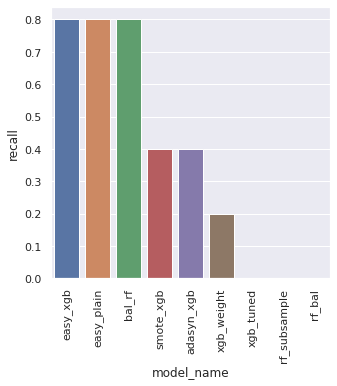

In [88]:
plt.figure(figsize=(5, 5))
sns.barplot(x=model_scores.model_name, y="recall", data=model_scores)
plt.xticks(rotation=90)